# Practice 1
**Author: Jorge Vázquez Pérez**

## Table of Contents

1. [Develop a quantum algorithm based on gates and circuits](#apartado1)
    + [QPE explanation](#apartado1a)
    + [QPE distributed](#apartado1b)
2. [Characterize the circuit](#apartado2)
3. [Run the circuit](#apartado3)
4. [Export/import the circuit](#apartado4)

In this practice the distributed version of the Quantum Phase Estimation (QPE) algorithm is going to be carried out along with an explanation of its difficulties and details. First of all, before any circuit and algorithm implementation all the necessary imports will be carried out.

In [1]:
import math
import numpy as np

from bitstring import BitArray

# Importing Qiskit
from qiskit import IBMQ, Aer, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Gate

from qiskit.circuit.library import QFT
from qiskit.circuit.library import PhaseGate

## 1. Develop a quantum algorithm based on gates and circuits <a class="anchor" id="apartado1"></a>

First, we will develop the standard Quantum Phase Estimation circuit to gain an understanding of the intricacies of this algorithm. After we have clarified all the concepts, we will explain the distributed version. This version is quite similar, with the addition of two subcircuits known as Cat Entangler and Car Disentangler. These subcircuits are utilized in the teleportation protocol in numerous quantum computing applications, including distributed quantum computing. It is important to note that the mathematical explanations of the circuit will be omitted, but can be found in the [Qiskit Textbook](https://learn.qiskit.org/course/ch-algorithms/quantum-phase-estimation).

### QPE explanation <a class="anchor" id="apartado1a"></a>
But first, let's explain what the QPE algorithm is all about. This algorithm, as its name suggests, aims to estimate a phase. More specifically,

> Given a state $|\psi\rangle$ and a gate $U$ such that $U|\psi\rangle = e^{2\pi i\theta}|\psi\rangle$, QPE tries to estimate the value of $\theta$.

Basically, what the QPE algorithm does is estimate the phase that a specific gate applies to a particular eigenvector. Once we have this information, let's construct the circuit and explain the purpose of each part. First, we define the quantum and classical registers used by the circuit

In [2]:
# Definition of the registers and the circuit (n_eval + 1 qubits)
n_eval = 4

qr_eval = QuantumRegister(n_eval, "eval")
qr_state = QuantumRegister(1, "\psi")
cl_eval = ClassicalRegister(n_eval, "cl_eval")

qr_list = [qr_eval, qr_state]
qpe = QuantumCircuit(*qr_list, cl_eval, name="QPE")

In the previous code snippet, we defined the `n_eval` variable, which represents the number of qubits used for evaluation and, consequently, determines the level of precision in phase estimation. For example, if the phase is $0.25$, setting `n_eval = 4` will yield a result of $0.2500$. However, if the phase were to be $0.3456734$, using `n_eval = 4` would result in a loss of precision. There is always a trade-off between the computational cost of adding qubits and the precision of phase estimation.

Now, the evaluation qubits are put into superposition, and the $|\psi\rangle$ qubit is initialized as the eigenvector of the $U$ gate that will be used. In this particular case, we have $|\psi\rangle = |1\rangle$ because $U = P(\phi)$ (the phase gate), as we will see next.

/home/jorge.vazquez.perez/miniconda3/envs/basic-quantum/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


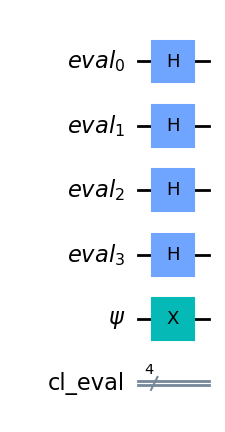

In [3]:
# Declaration of the gates
qpe.x(qr_state[0])
qpe.h(qr_eval)
qpe.draw("mpl")

As previously mentioned, the gate employed is the phase gate $P(\phi)$ which has the matrix form:

\begin{pmatrix}
1 & 0 \\
0 & e^{i\phi}.
\end{pmatrix}

Now it becomes evident not only why we use this gate but also why we set $|\psi\rangle = |1\rangle$, considering that $P(\phi) |1\rangle = e^{i\phi}|1\rangle$. This property of the phase gate enables us to set $\phi = 2\pi\theta$ and, consequently, makes it straightforward to test the algorithm (because $\theta$ precisely corresponds to the value returned by the QPE). It's important to emphasize that while this gate serves as an immediate choice for illustration purposes, $U$ can be any gate, provided we initialize $\psi$ to an appropriate eigenstate or another state that leads to an interesting outcome (as is the case with the value $|1\rangle$ and the modular multiplication gate used in Shor's algorithm, which precisely employs the QPE scheme).

Returning to our current scenario, we observe that the chosen gate is applied $2^{i}$ times to the $\psi$ qubit, controlled by the `n_eval` qubit.

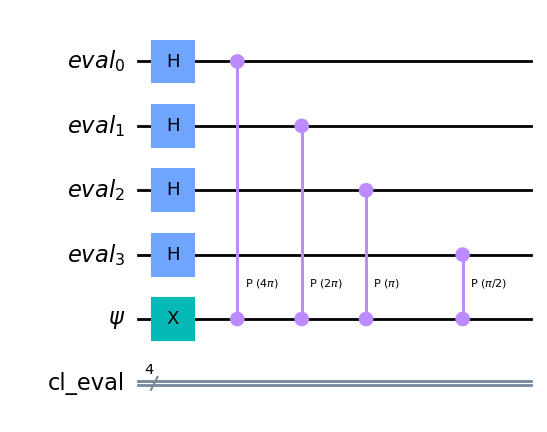

In [4]:
phase_input = 0.25

for j in range(n_eval):
        qpe.append(PhaseGate(theta = 2*math.pi*phase_input).power(2**(n_eval-j-1)).control(), qargs=[j] + qr_state[:])
qpe.draw("mpl")

And last but not least, the inverse of the Quantum Fourier Transform is applied at the end of the circuit, but only to the evaluation qubits. Following this step, specifically the evaluation qubits are measured, yielding a result for the quantum circuit. As we will see, the result obtained is not the exact phase aimed for; rather, it is a binary number $b$. When this binary number is represented in decimal form and divided by $2^{n\_eval}$, it precisely returns the value of $\theta$:

$$\theta = \frac{b}{2^{n\_eval}}$$

This will be tested in the [Run the circuit](#apartado3) section.

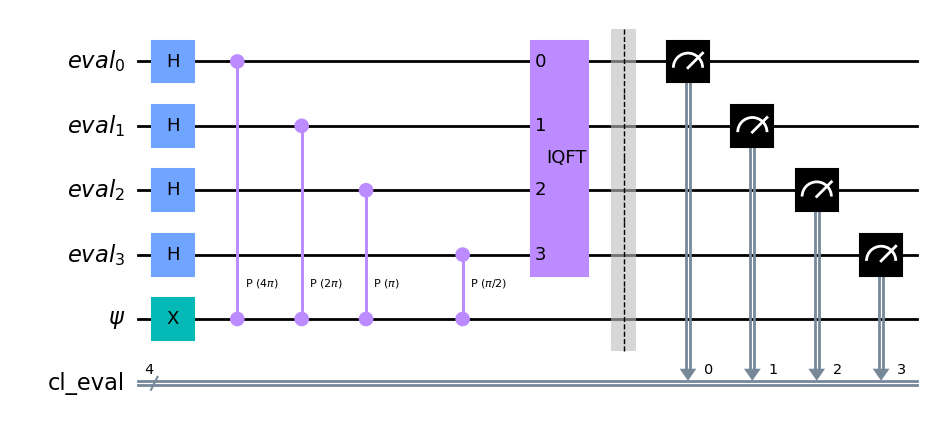

In [5]:
# Add the inverse QFT in both cases and measure the eval qubits  
iqft = QFT(n_eval, inverse=True, do_swaps=False)  
qpe.append(iqft, qargs=qr_eval)
qpe.barrier()
for n in range(n_eval):
    qpe.measure(qr_eval[n],cl_eval[n])

qpe.draw("mpl")

Below, the entire construction is encapsulated within a method that returns the circuit. This allows us to easily reuse the circuit within the notebook whenever needed.

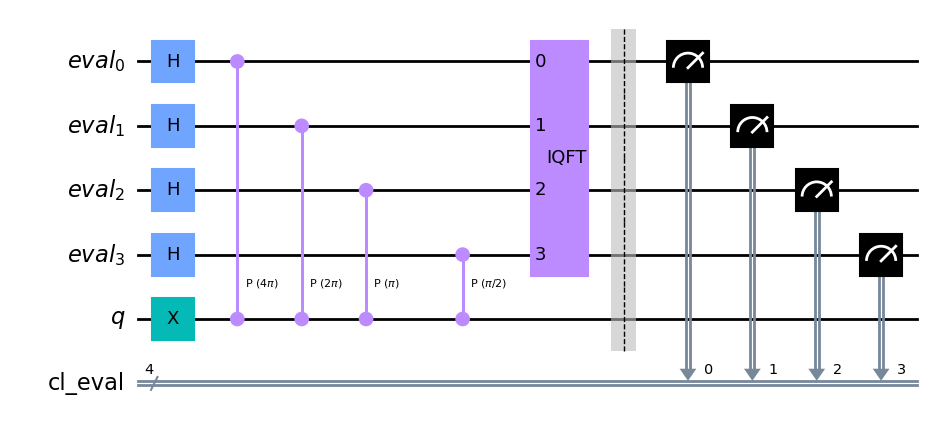

In [6]:
def qpe(gate: Gate = PhaseGate, psi: np.ndarray=[0,1], n_eval: int=4, param: float=0, measurements: bool = True):
    """Usual implementation of QPE algorithm."""

    # Definition of the registers and the circuit (n + 1 qubits)
    qr_eval = QuantumRegister(n_eval, "eval")
    qr_state = QuantumRegister(1, "q")
    cl_eval = ClassicalRegister(n_eval, "cl_eval")
    
    qr_list = [qr_eval, qr_state]
    qpe = QuantumCircuit(*qr_list, cl_eval, name="QPE")
    
    # Declaration of the gates
    qpe.x(qr_state[0])
    qpe.h(qr_eval)
    for j in range(n_eval):
        qpe.append(gate(param).power(2**(n_eval-j-1)).control(), qargs=[j] + qr_state[:])
    
    # Add the inverse QFT in both cases and measure the eval qubits  
    iqft = QFT(n_eval, inverse=True, do_swaps=False)  
    qpe.append(iqft, qargs=qr_eval)
    qpe.barrier()
    if measurements:
        for n in range(n_eval):
            qpe.measure(qr_eval[n],cl_eval[n])
    return qpe

phase_input = 0.25
qpe_monol = qpe(param = 2*math.pi*phase_input)
qpe_monol.draw("mpl")

### Distributed version <a class="anchor" id="apartado1b"></a>

After the classic QPE version was explained, we move into the distributed version. In this version, everything is exactly the same with the exception of the control nature of the $U$ gate. In the monolithic case, a simple control operation is performed between the gate and the $i^{th}$ evaluation qubit. However, in the distributed version, we need to perform a Cat Entangler before the control operation and a Cat Disentangler after. Let's see how these two gates are constructed and let's explain the effect.

1. **Cat Entangler**. This circuit performs an operation such that if a qubit $q_0$ is in the state $|q_0\rangle = \alpha|0\rangle + \beta|1\rangle$, then, after the cat entangler, the qubits $q_0$, $q_1$, and $q_2$ will be in the state $|q_2q_1q_0\rangle = \alpha|000\rangle + \beta|101\rangle$, with $q_0$, $q_1$, and $q_2$ representing the same qubits as shown in the circuit below. The utility of this operation is that now, operating on qubit $q_2$ is equivalent to operating on qubit $q_0$. This is highly valuable in distributed quantum computing because if $q_0$ and $q_2$ were in different quantum computers, we could perform operations on the quantum computer containing $q_2$ using the information contained in $q_0$. This could be achieved by generating two entangled pairs (in our case, $q_1$ and $q_2$) and sending them to different computers (with $q_1$ sent to the computer containing $q_0$ and $q_2$ sent to another one). The generation of this entangled state is simulated in Qiskit using the bell circuit that can be seen before the barrier.

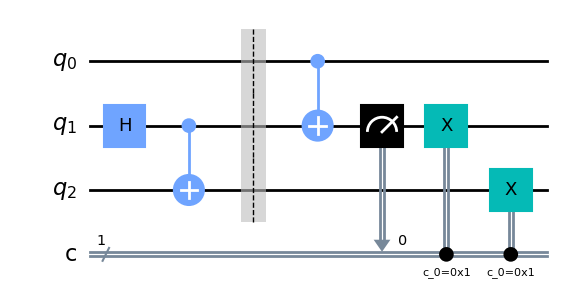

In [7]:
def cat_entangler(num_qubits: int = 3):
    cat_ent = QuantumCircuit(3, 1)
    
    # Create the cat state
    cat_ent.h(1)
    for i_qubit in range(1,num_qubits-1):
        cat_ent.cx(i_qubit, i_qubit+1)
    
    # Execute the teleportation
    cat_ent.barrier()

    cat_ent.cx(0, 1)
    cat_ent.measure(1, 0)
    for i_qubit in range(1,num_qubits):
        cat_ent.x(i_qubit).c_if(0, 1)
    
    return cat_ent

cat_ent = cat_entangler()
cat_ent.draw("mpl")

2. **Cat Disentangler**. This circuit is, precisele the inverse of the Cat Entangler. It is applied after all the operations are done to set all the entangle pairs again to the state $|0\rangle$ and leaves $q_0$ with the state that should have as if the operations were performed without the Cat Entangler.

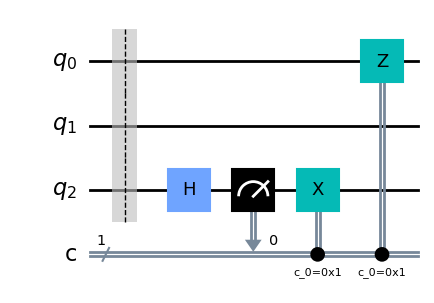

In [8]:
def cat_disentangler(num_qubits: int = 3):
    cat_ent = QuantumCircuit(3, 1)
    
    # Create the cat state
    cat_ent.barrier()
    for i_qubit in range(2,num_qubits):
        cat_ent.h(i_qubit)

    for i_qubit, j_clbit in zip(range(2, num_qubits), range(num_qubits-2)):
        cat_ent.measure(i_qubit, j_clbit)
        cat_ent.x(i_qubit).c_if(j_clbit, 1)
        cat_ent.z(0).c_if(j_clbit, 1)
    
    return cat_ent

cat_dis = cat_disentangler()
cat_dis.draw("mpl")

And just as we did before with the monolithic version, we will incorporate the whole construction into a function for reusability purposes. We did not enter into the analythic explanation of this circuits because it exceeds the scope of the practice.

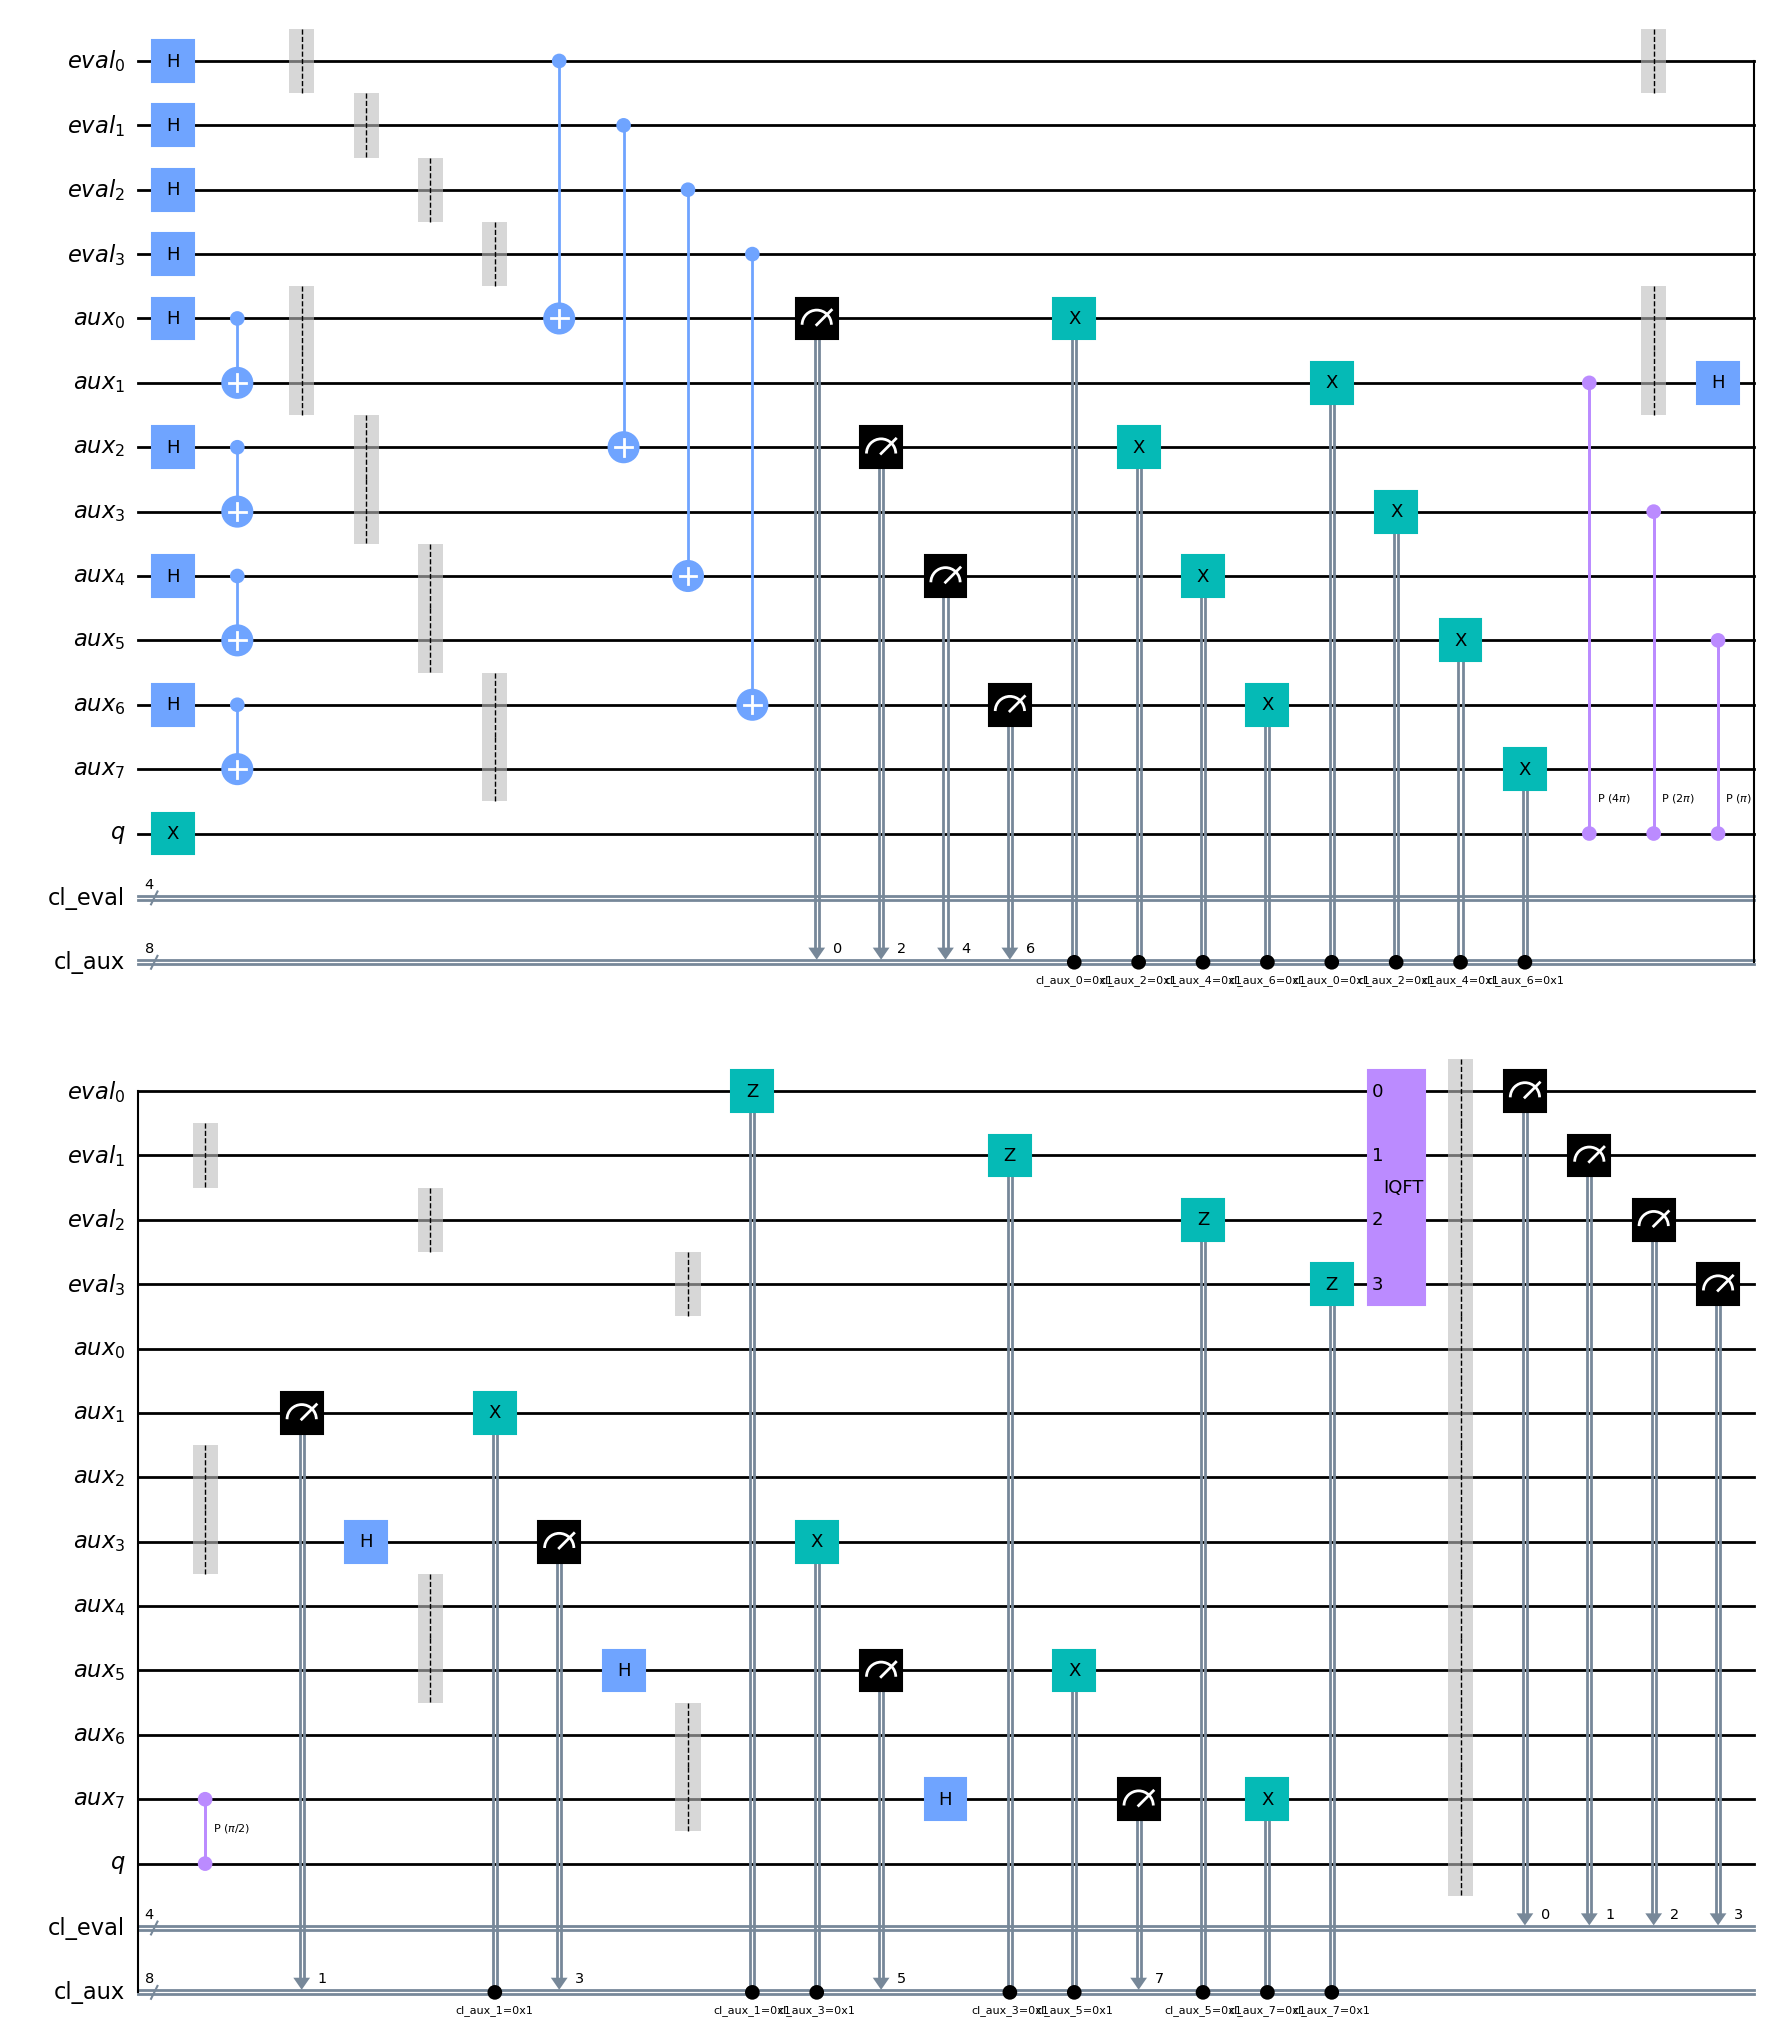

In [9]:
def qpe_distributed(gate: Gate = PhaseGate, psi: np.ndarray=[0,1], n_eval: int=4, param: float=0, measurements: bool = True):
    """Distributed implementation using cat entangler and cat disantangler."""

    # Definition of the registers and the circuit (3n + 1 qubits)
    qr_eval = QuantumRegister(n_eval, "eval")
    qr_aux = QuantumRegister(2*n_eval, "aux")
    qr_state = QuantumRegister(1, "q")
    cl_eval = ClassicalRegister(n_eval, "cl_eval")
    cl_aux = ClassicalRegister(2*n_eval, "cl_aux")

    qr_list = [qr_eval, qr_aux, qr_state]
    cl_list = [cl_eval, cl_aux]
    qpe = QuantumCircuit(*qr_list, *cl_list, name="QPE")

    # Declaration of the gates
    qpe.x(qr_state[0])
    qpe.h(qr_eval)

    cat_ent = cat_entangler()
    cat_dis = cat_disentangler()

    for j in range(n_eval):
        qubits_list = [qr_eval[j], qr_aux[2*j], qr_aux[2*j + 1]]
        qpe.compose(cat_ent, qubits=qubits_list, clbits=[cl_aux[2*j]], inplace=True)
        qpe.append(gate(param).power(2**(n_eval-j-1)).control(), qargs=[qr_aux[2*j + 1]] + qr_state[:])
        qpe.compose(cat_dis, qubits=qubits_list, clbits=[cl_aux[2*j+1]], inplace=True)

    # Add the inverse QFT in both cases and measure the eval qubits  
    iqft = QFT(n_eval, inverse=True, do_swaps=False)  
    qpe.append(iqft, qargs=qr_eval)
    qpe.barrier()
    if measurements:
        for n in range(n_eval):
            qpe.measure(qr_eval[n],cl_eval[n])

    return qpe

phase_input = 0.25
qpe_distr = qpe_distributed(param=2*math.pi*phase_input)
qpe_distr.draw("mpl")

## Characterize the circuit <a class="anchor" id="apartado2"></a>

In this brief chapter, we are going to analyze the width, size, and depth of the circuit.

1. **Width**: The width is calculated by adding the total number of qubits used and the classical bits.
2. **Size**: The size is determined by the number of gates used in the circuit.
3. **Depth**: The depth is the count of layers in the circuit, which is the number of gates in the longest path from the beginning to the end, considering all qubits.

In [10]:
print("The width of the circuit is: {}".format(qpe_distr.width()))
print("The size of the circuit is: {}".format(qpe_distr.size()))
print("The depth of the circuit is: {}".format(qpe_distr.depth()))

The width of the circuit is: 25
The size of the circuit is: 54
The depth of the circuit is: 16


It is interesting to compare these values with the values of the monolithic version and observe that all these metrics are significantly larger in the distributed version.

In [11]:
print("The width of the circuit is: {}".format(qpe_monol.width()))
print("The size of the circuit is: {}".format(qpe_monol.size()))
print("The depth of the circuit is: {}".format(qpe_monol.depth()))

The width of the circuit is: 9
The size of the circuit is: 14
The depth of the circuit is: 7


Moreover, if we now decompose the circuit into $U$ gates, we observe a significant increase in the number of gates. It's important to note that the `reps=9` argument in the `decompose()` method represents the number of times the method needs to be applied to have only $U$ gates.

(At the beginning of the notebook, we referred to $U$ as a generic unitary gate, but in this context, it represents the generic representation of a unitary gate employed by Qiskit.)

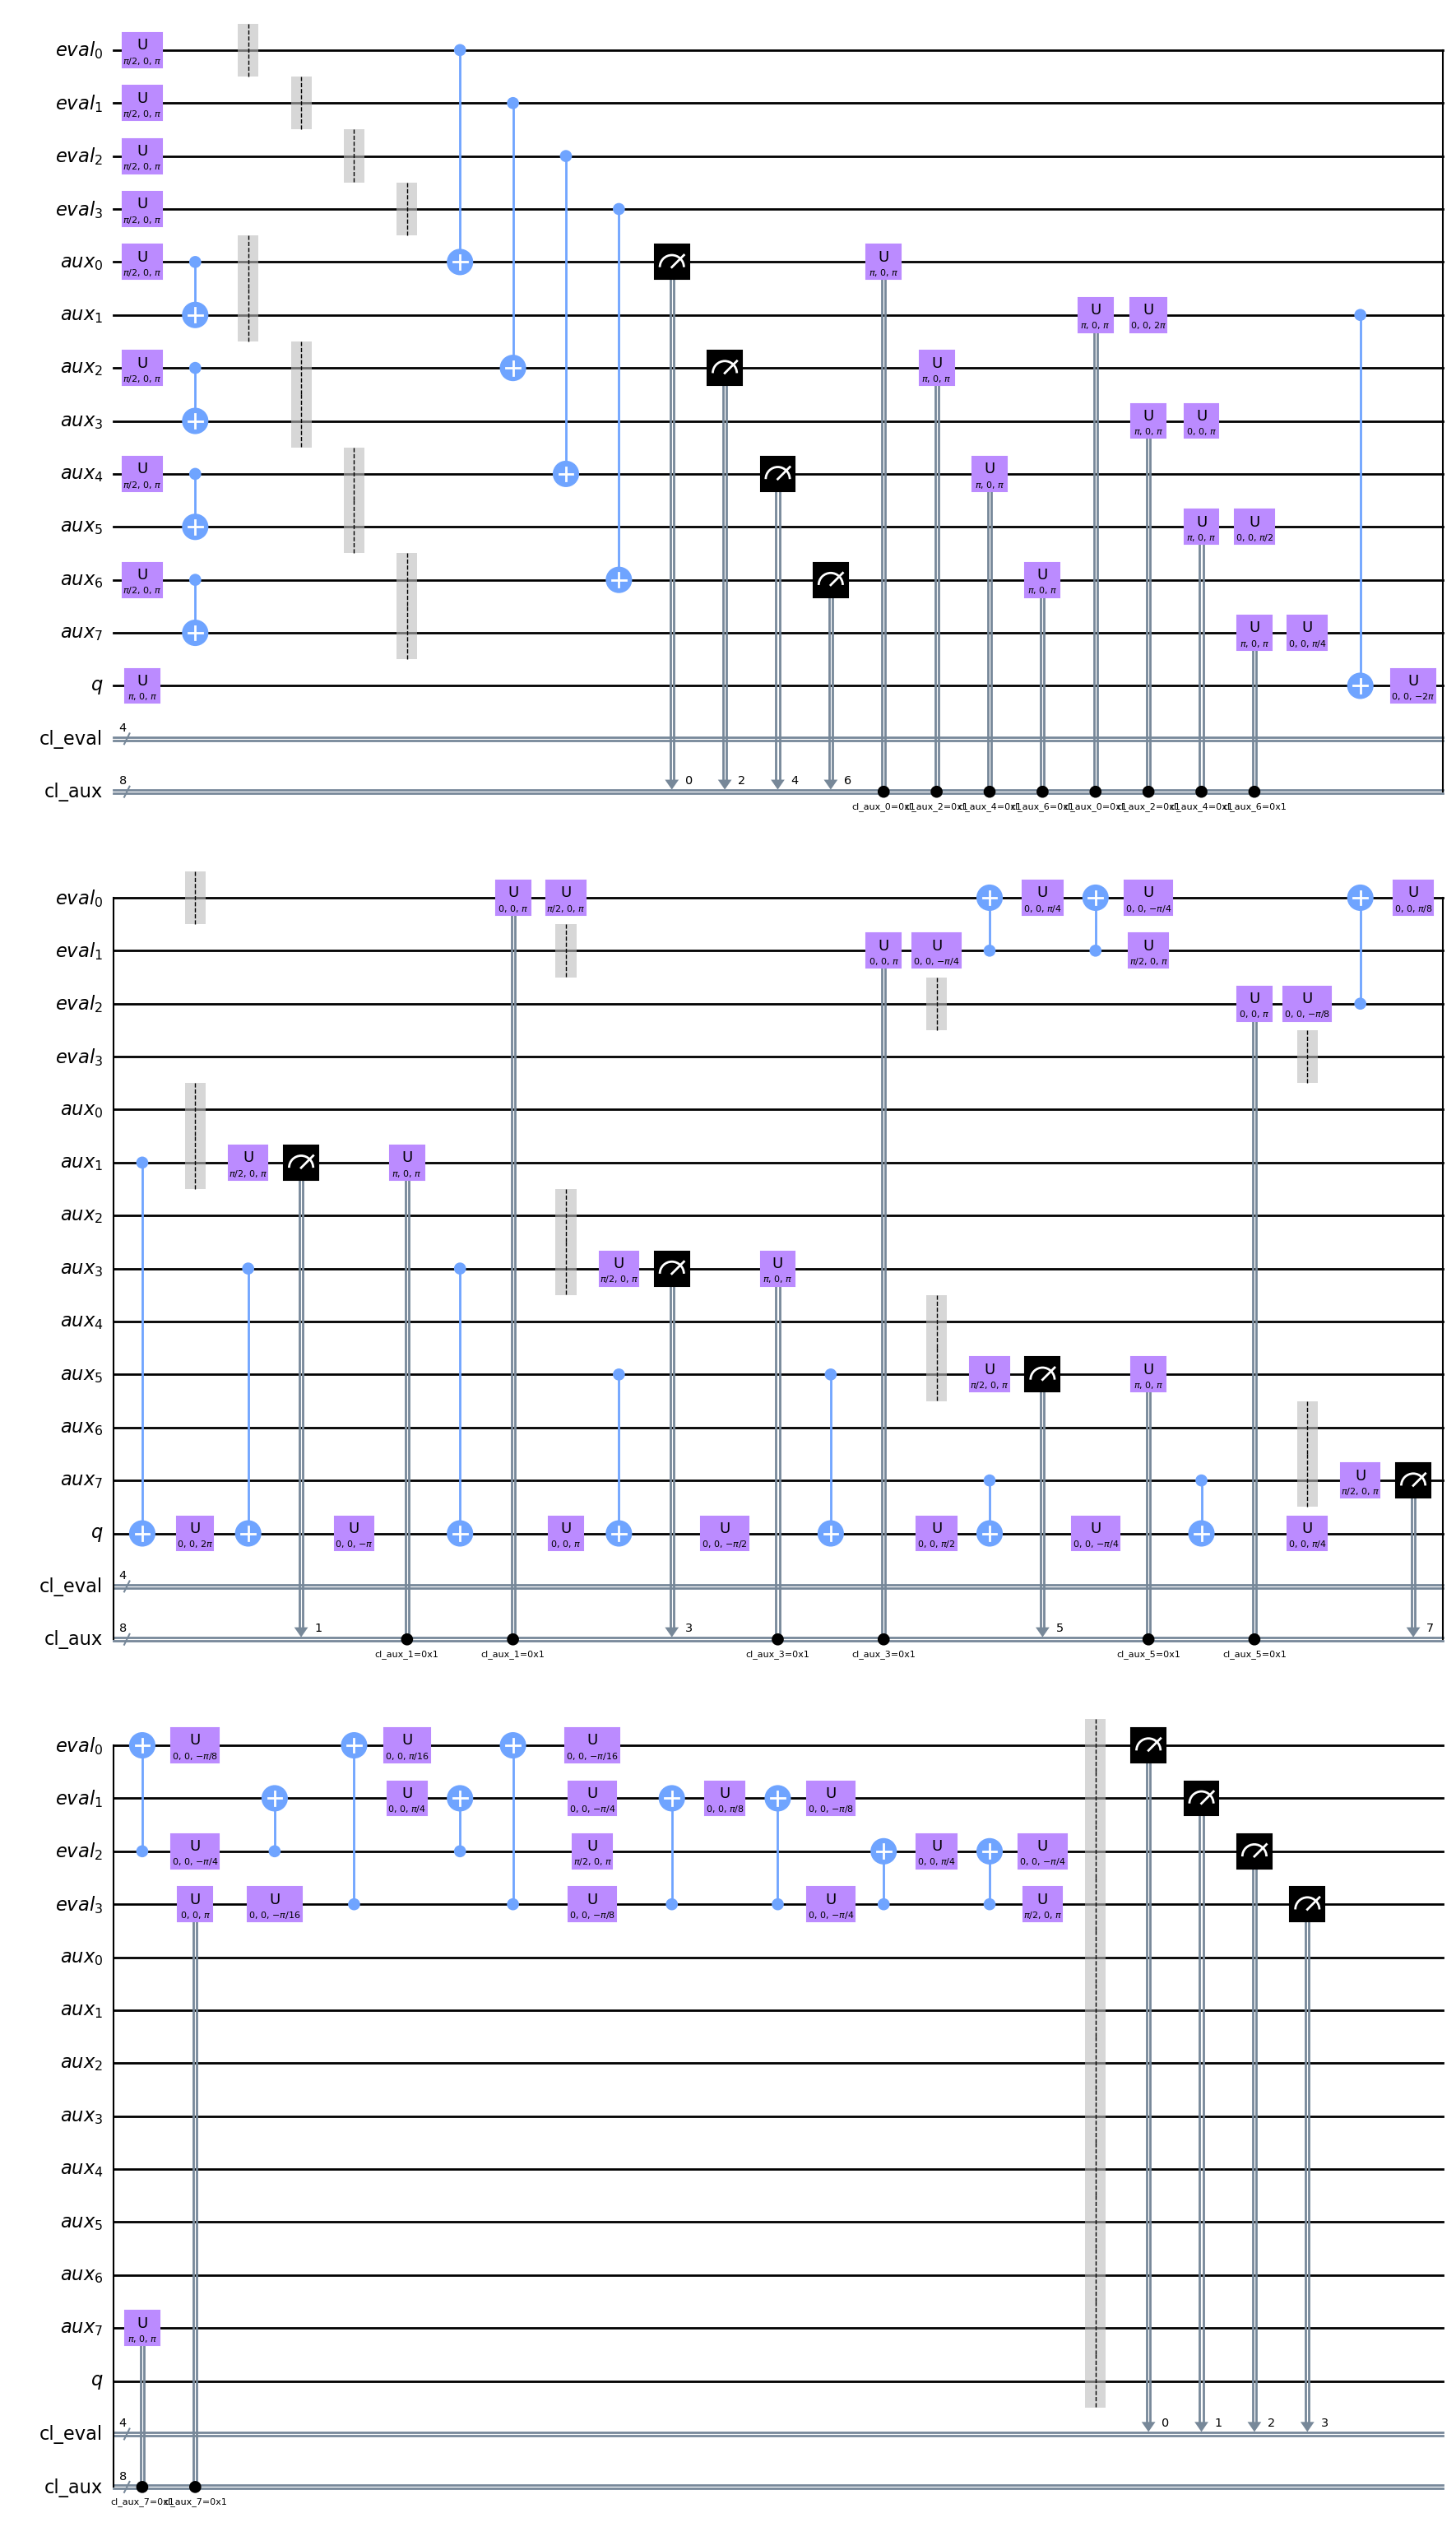

In [12]:
qpe_distr_decomposed = qpe_distr.decompose(reps=9)
qpe_distr_decomposed.draw("mpl")

As we expected, the previous metrics experience a significant increase, with the exception of the width, which remains unaltered (because we didn't add any qubits).

In [13]:
print("The width of the circuit is: {}".format(qpe_distr_decomposed.width()))
print("The size of the circuit is: {}".format(qpe_distr_decomposed.size()))
print("The depth of the circuit is: {}".format(qpe_distr_decomposed.depth()))

The width of the circuit is: 25
The size of the circuit is: 103
The depth of the circuit is: 40


## Run the circuit <a class="anchor" id="apartado3"></a>

Now it's time to run the circuits we constructed and see the results. First, we are going to define some useful functions to postprocess the data obtained in the circuit.

1. `_process_answer`: In the distributed version, many intermediate measurements are performed, which can interfere with the result we are interested in, which is the value of the evaluation qubits. This function eliminates those intermediate measurement values and retrieves only the valuable ones.
2. `execute_measurements`: A function to make the measurements more reusable and readable.
3. `get_phase`: Retrieves the dictionary containing the results of the evaluation qubits and performs the classical postprocessing as previously explained to obtain the value of $\theta$:

   $$\theta = \frac{b}{2^{n\_eval}}$$

In [14]:
from qiskit.result.result import Result

def _process_answer(counts: dict) -> dict:
    """Auxiliar funtion to process the counts and erase the intermediate measures from the result.
    Args:
        counts: Result from the measurements of the quantum circuit.
    Returns:
        dict: Dictionary with the significant measures.
    """
    new_dict = {}
    for key, count in counts.items():
        keys = key.split()
        if len(keys) < 2:
            return
        new_key = keys[1]
        if new_key in new_dict:
            new_dict[new_key] = new_dict[new_key] + count
        else:
            new_dict[new_key] = count
    return new_dict

def execute_measurements(circuit: QuantumCircuit, simulator: str = "aer_simulator") -> Result:
    """Function to perform a measurement in an indicated backend simulator.
    Args:
        circuit: Quantum circuit to measure.
        simulator: Name of the simulator
    Returns:
        Result: A Result Qiskit object with the results of the measurements.
    """
    sim = Aer.get_backend(simulator)
    results = sim.run(transpile(circuit, sim)).result()

    return results

def get_phase(counts: dict, n_eval: int = 4, filter_counts: bool = False, return_counts: bool = False) -> float:
    """Function calculate the phase.
    Args:
        counts: Counts of the measurement results.
        n_eval: Number of evaluation qubits (precision).
        filter_counts: Bool value to determine whether to apply _process_answer.
        return_counts: Bool to determine if the counts are returned or only the phase value.
    Returns:
        float: Guess of the phase.
    """
    
    if filter_counts:
        counts = _process_answer(counts=counts)

    evaluation = BitArray(bin = max(counts, key=counts.get)).int
    phase = evaluation/math.pow(2, n_eval)

    if return_counts:
        return counts, phase
    return phase

Let's now see if the circuit behaves as expected executing it and processing the results.

In [15]:
theta = 0.25
qpe_distr = qpe_distributed(PhaseGate, param=2*math.pi*theta)

# Simulation of the circuit
results = execute_measurements(qpe_distr, "qasm_simulator")
counts = results.get_counts()

# Post process of the results
filtered_counts, phase = get_phase(counts, filter_counts=True, return_counts=True)

print("\n··· Counts obtained ···")
print("The counts of the measurements are:")
print(filtered_counts)

print("\n··· Results after postprocessing ···")
print("The value of the phase is: {phase:.{n_eval}f}".format(phase=phase, n_eval=4))


··· Counts obtained ···
The counts of the measurements are:
{'0100': 1024}

··· Results after postprocessing ···
The value of the phase is: 0.2500


In the previous case, we observed that the phase is calculated with perfect precision and certainty, as the result of the measurement is always the same value $b = 0100$. Now, let's use another phase value and see what happens.

In [16]:
theta = 0.333
qpe_distr = qpe_distributed(PhaseGate, param=2*math.pi*theta)

# Simulation of the circuit
results = execute_measurements(qpe_distr, "qasm_simulator")
counts = results.get_counts()

# Post process of the results
filtered_counts, phase = get_phase(counts, filter_counts=True, return_counts=True)

print("\n··· Counts obtained ···")
print("The counts of the measurements are:")
print(filtered_counts)

print("\n··· Results after postprocessing ···")
print("The value of the phase is: {phase:.{n_eval}f}".format(phase=phase, n_eval=4))


··· Counts obtained ···
The counts of the measurements are:
{'0111': 29, '0000': 6, '0011': 14, '0110': 166, '0001': 6, '0100': 47, '1000': 10, '0101': 713, '0010': 15, '1110': 4, '1001': 4, '1111': 4, '1010': 4, '1011': 2}

··· Results after postprocessing ···
The value of the phase is: 0.3125


In this case, the precision is not perfect, and the measurement is not deterministic. We can observe that the value $b = 0101$ accumulates the majority of the probability, but not all of it. This is because 100% certainty and precision are only obtained when $\theta$ divides ${2^n}$ and when the number of evaluation qubits is sufficient to represent the $2^n$ value, as is evident. In any other case, the obtained value will be approximate, and the more evaluation qubits employed, the closer the result will get to the actual value.

Now, for the statevector simulation, we will revert to the monolithic version due to the impossibility of this simulator to cope with intermediate measurements. However, this is not a problem because we have seen that the distributed version works correctly, and with the statevector of the monolithic version, we will observe the state that the measurements in the distributed version reflected. It's important to note that in the statevector simulation, the QPE circuit is constructed without measurements to avoid state collapse, and the last qubit (which represents $|\phi\rangle$) always maintains the $|1\rangle$ value.

In [17]:
phase_input = 0.25
qpe_circuit = qpe(param = 2*math.pi*phase_input, measurements=False)

# Simulation of the circuit
results = execute_measurements(qpe_circuit, "statevector_simulator")
psi = results.get_statevector(qpe_circuit)

psi.draw("latex")

<IPython.core.display.Latex object>

And with $\theta = 0.333 \neq \frac{1}{2^m}, \; \forall m \in \mathbb{N}$.

In [18]:
phase_input = 0.333
qpe_circuit = qpe(param = 2*math.pi*phase_input, measurements=False)

# Simulation of the circuit
results = execute_measurements(qpe_circuit, "statevector_simulator")
psi = results.get_statevector(qpe_circuit)

psi.draw("latex")

<IPython.core.display.Latex object>

To conclude this section, we will visualize the results using the `qsphere` available in Qiskit. This will show how the probability accumulates in the $|10101\rangle$ state, as we observed in the previous statevector and in the measurements obtained using the qasm_simulator.

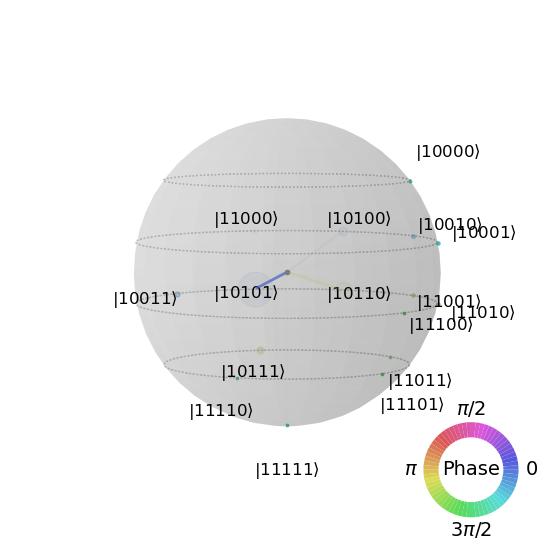

In [19]:
from qiskit.quantum_info import DensityMatrix
from qiskit.visualization import plot_state_city, plot_state_qsphere

phase_input = 0.333
qpe_circuit = qpe(param = 2*math.pi*phase_input, measurements=False)

# Simulation of the circuit
results = execute_measurements(qpe_circuit, "statevector_simulator")
psi = results.get_statevector(qpe_circuit)

plot_state_qsphere(psi)

## Export/import the circuit <a class="anchor" id="apartado4"></a>

In this final part, the interoperability of Qiskit with OpenQASM is going to be explained. First of all, as it happened before with the statevector simulator, the `qasm()` method doesn't support intermediate measurements, as can be seen below.

In [20]:
theta = 0.25
qpe_distr = qpe_distributed(PhaseGate, param=2*math.pi*theta)
qasm_str = qpe_distr.qasm()

print(qasm_str)

QASM2ExportError: "OpenQASM 2 can only condition on registers, but got '{operation.condition[0]}'"

Due to this limitation, the circuit we are going to employ in this section is the monolithic version, which, as demonstrated below, can be easily translated to OpenQASM.

In [21]:
phase_input = 0.25
qpe_circuit = qpe(param = 2*math.pi*phase_input)
qasm_str = qpe_circuit.qasm()

print(qasm_str)

OPENQASM 2.0;
include "qelib1.inc";
gate gate_IQFT_dg q0,q1,q2,q3 { h q0; cp(-pi/2) q1,q0; h q1; cp(-pi/4) q2,q0; cp(-pi/2) q2,q1; h q2; cp(-pi/8) q3,q0; cp(-pi/4) q3,q1; cp(-pi/2) q3,q2; h q3; }
gate gate_IQFT q0,q1,q2,q3 { gate_IQFT_dg q0,q1,q2,q3; }
qreg eval[4];
qreg q[1];
creg cl_eval[4];
x q[0];
h eval[0];
h eval[1];
h eval[2];
h eval[3];
cp(4*pi) eval[0],q[0];
cp(2*pi) eval[1],q[0];
cp(pi) eval[2],q[0];
cp(pi/2) eval[3],q[0];
gate_IQFT eval[0],eval[1],eval[2],eval[3];
barrier eval[0],eval[1],eval[2],eval[3],q[0];
measure eval[0] -> cl_eval[0];
measure eval[1] -> cl_eval[1];
measure eval[2] -> cl_eval[2];
measure eval[3] -> cl_eval[3];



To perform the reverse translation (from an OpenQASM string to a Qiskit circuit), we need to define the phase gate as a custom instruction using the `CustomInstruction` object. This is necessary due to the absence of this operation in the translation protocol established by Qiskit. As we can see, the circuit after the translation remains the same as before.

/home/jorge.vazquez.perez/miniconda3/envs/basic-quantum/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


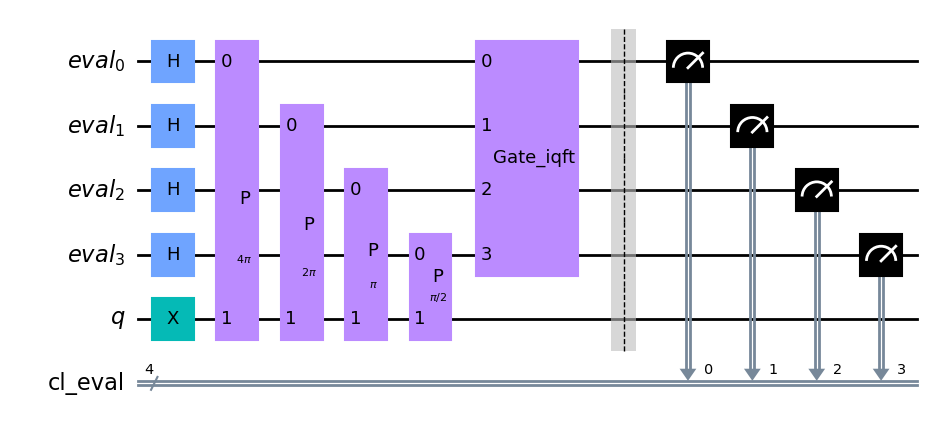

In [22]:
from qiskit.qasm2 import loads, CustomInstruction
customs = [
    CustomInstruction(name="cp", num_params=1, num_qubits=2, constructor=PhaseGate, builtin=True),
]

qpe_circuit_qasm = loads(qasm_str, custom_instructions=customs)
qpe_circuit_qasm.draw("mpl")

And, to check that the circuit is precisely the same circuit we can execute it as we did in the previous section and see that the results are precisely the same.

In [23]:
# Simulation of the circuit
results = execute_measurements(qpe_circuit_qasm, "qasm_simulator")
counts = results.get_counts()

# Post process of the results
phase = get_phase(counts)

print("\n··· Results after postprocessing ···")
print("The value of the phase is: {phase:.{n_eval}f}".format(phase=phase, n_eval=4))


··· Results after postprocessing ···
The value of the phase is: 0.2500
